In [9]:
import pandas as pd

#### Using minmax only

In [44]:
from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv("merged_data.csv")

data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data.drop(columns=["Recession"]))
scaled_data = pd.DataFrame(scaled_features, columns=data.columns[:-1], index=data.index)
scaled_data['Recession'] = data['Recession']  


#### Using standard

In [116]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
data = pd.read_csv("merged_data.csv")
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE')

# Separate columns for different scalers
standard_scaler_columns = ['gdp_percent_change', 'inflation_percent_change', 'unemployment_percent_change']
min_max_scaler_columns = [col for col in data.columns if col not in standard_scaler_columns + ['DATE', 'Recession']]

# Apply StandardScaler to selected columns
standard_scaler = StandardScaler()
data[standard_scaler_columns] = standard_scaler.fit_transform(data[standard_scaler_columns])

# Apply MinMaxScaler to the remaining columns (except target and date)
min_max_scaler = MinMaxScaler()
data[min_max_scaler_columns] = min_max_scaler.fit_transform(data[min_max_scaler_columns])

# Check the processed data to ensure proper scaling
data.head()

,DATE,gdp_percent_change,inflation_percent_change,unemployment_percent_change,Slope,LongTermRate,ZeroCouponYield1Y,ZeroCouponYield2Y,ZeroCouponYield3Y,ZeroCouponYield4Y,...,ZeroCouponYield10Y,InstantaneousForwardRate1Y,InstantaneousForwardRate2Y,InstantaneousForwardRate3Y,InstantaneousForwardRate4Y,InstantaneousForwardRate5Y,InstantaneousForwardRate6Y,InstantaneousForwardRate7Y,InstantaneousForwardRate10Y,Recession
0,1961-06-30,1.086024,-0.985611,-0.816087,0.463769,0.160110,0.184313,0.211179,0.226079,0.234114,...,0.251932,0.221101,0.255323,0.261874,0.257451,0.249817,0.241269,0.232560,0.261796,0
1,1961-07-31,1.074744,-0.140003,0.518665,0.446137,0.164034,0.175899,0.205111,0.222832,0.233020,...,0.250386,0.214934,0.255350,0.266802,0.264082,0.256963,0.248580,0.239930,0.267664,0
2,1961-08-31,1.136083,-0.774774,-1.722587,0.452569,0.169935,0.186022,0.213567,0.231503,0.242082,...,0.257355,0.220417,0.263449,0.276710,0.274720,0.267886,0.259622,0.251027,0.277308,0
3,1961-09-30,1.124163,-0.564219,0.539276,0.453090,0.165211,0.188656,0.215156,0.231022,0.239958,...,0.256174,0.224142,0.260710,0.270093,0.266605,0.259255,0.250815,0.242153,0.269865,0
4,1961-10-31,1.112397,-0.985611,-0.868703,0.455216,0.152620,0.183568,0.209070,0.224726,0.233455,...,0.251044,0.218294,0.253516,0.263542,0.258436,0.248079,0.236492,0.225149,0.259681,0


In [117]:
import numpy as np
# Redefine the train-test split
data['DATE'] = pd.to_datetime(data['DATE'])
train_data = data.iloc[:548] #2016-12-31
test_data = data.iloc[549:]

X_train, y_train = train_data.drop(columns=['Recession']), train_data['Recession']
X_test, y_test = test_data.drop(columns=['Recession']), test_data['Recession']

# Verify that y_test has no NaN values
print("y_test NaNs:", y_test.isna().sum())

def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features.iloc[i:i + window_size].values)  # Use .iloc for row slicing
        y.append(target.iloc[i + window_size])  # Use .iloc for proper indexing
    return np.array(X), np.array(y)


# Create sequences
window_size = 8
X_train = X_train.select_dtypes(exclude=['datetime64[ns]'])
X_test = X_test.select_dtypes(exclude=['datetime64[ns]'])
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

# Check the shapes of the generated sequences
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)

y_test NaNs: 0
X_train_seq shape: (540, 8, 21)
y_train_seq shape: (540,)
X_test_seq shape: (188, 8, 21)
y_test_seq shape: (188,)


In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=40,
    batch_size=32,
    verbose=1
)

# Evaluate performance
print(history.history)


Epoch 1/40
17/17 [==============================] - 5s 57ms/step - loss: 0.4243 - accuracy: 0.8389 - val_loss: 0.3736 - val_accuracy: 0.8723
Epoch 2/40
17/17 [==============================] - 0s 24ms/step - loss: 0.2643 - accuracy: 0.9000 - val_loss: 0.3231 - val_accuracy: 0.8617
Epoch 3/40
17/17 [==============================] - 0s 23ms/step - loss: 0.2322 - accuracy: 0.9074 - val_loss: 0.2972 - val_accuracy: 0.8777
Epoch 4/40
17/17 [==============================] - 0s 29ms/step - loss: 0.1982 - accuracy: 0.9037 - val_loss: 0.2957 - val_accuracy: 0.8777
Epoch 5/40
17/17 [==============================] - 0s 20ms/step - loss: 0.1894 - accuracy: 0.9111 - val_loss: 0.2826 - val_accuracy: 0.8777
Epoch 6/40
17/17 [==============================] - 0s 20ms/step - loss: 0.1719 - accuracy: 0.9074 - val_loss: 0.2691 - val_accuracy: 0.8936
Epoch 7/40
17/17 [==============================] - 0s 21ms/step - loss: 0.1591 - accuracy: 0.9259 - val_loss: 0.2804 - val_accuracy: 0.8936
Epoch 8/40
17

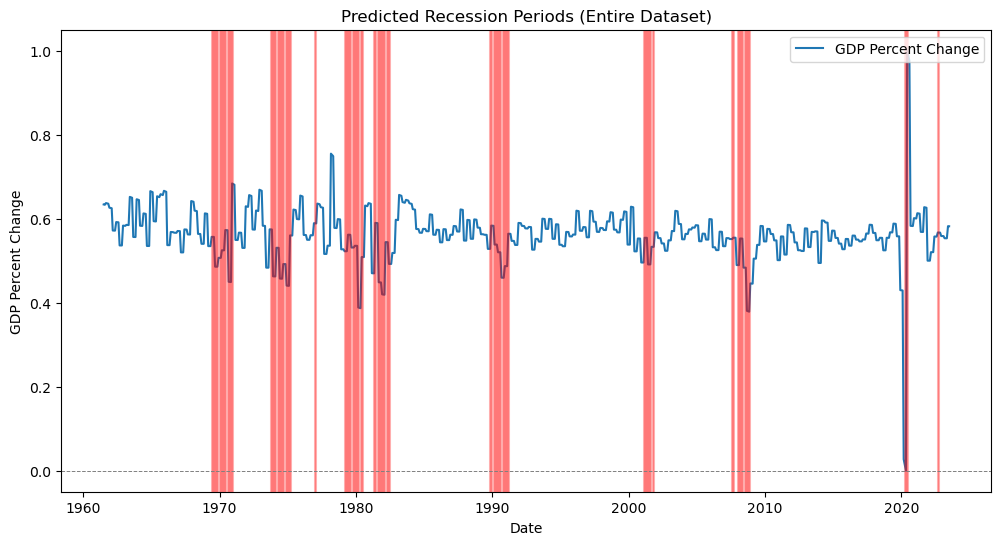

,Date,Recession Probability,Predicted Recession
0,1962-02-28,4.919008e-07,0
1,1962-03-31,5.299814e-07,0
2,1962-04-30,6.871143e-07,0
3,1962-05-31,7.630379e-07,0
4,1962-06-30,7.336020e-07,0


In [119]:
# Redefine create_sequences function
def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features.iloc[i:i + window_size].values)
        y.append(target.iloc[i + window_size])  # Align target with the end of the sequence
    return np.array(X), np.array(y)

# Load and preprocess the dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Assuming scaled_data and best_model exist, otherwise redefine them here
# Scale GDP, Inflation, Unemployment with StandardScaler
# Scale other features with MinMaxScaler

# Define window size
# Re-create sequences for the entire dataset

data = data.select_dtypes(exclude=['datetime64[ns]'])

X_full_seq, y_full_seq = create_sequences(
    data.drop(columns=['Recession']),
    data['Recession'],
    window_size
)

# Predict recession probabilities on the entire dataset
recession_probabilities_full = model.predict(X_full_seq)

# Convert probabilities to binary predictions (threshold = 0.5)
recession_predictions_full = (recession_probabilities_full >= 0.5).astype(int).flatten()

# Map predictions back to the original dates (align with window end dates)
recession_dates_full = scaled_data.index[window_size:]  # Dates corresponding to the sequences

# Create a DataFrame with predicted recession dates and probabilities
recession_results_full = pd.DataFrame({
    'Date': recession_dates_full,
    'Recession Probability': recession_probabilities_full.flatten(),
    'Predicted Recession': recession_predictions_full
})

# Visualize the results
import matplotlib.pyplot as plt

# Plot a relevant economic indicator (e.g., GDP)
plt.figure(figsize=(12, 6))
plt.plot(scaled_data.index, scaled_data['gdp_percent_change'], label='GDP Percent Change')

# Highlight predicted recession periods
for date in recession_results_full.loc[recession_results_full['Predicted Recession'] == 1, 'Date']:
    plt.axvline(x=date, color='red', alpha=0.3)  # Vertical lines for recessions

# Add labels and legend
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # Zero line for reference
plt.title('Predicted Recession Periods (Entire Dataset)')
plt.xlabel('Date')
plt.ylabel('GDP Percent Change')
plt.legend()
plt.show()

# Display the first few rows of the results table
recession_results_full.head()
